In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'alzheimer-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2029496%2F3364939%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T173410Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D433d07bd71eaa78afb449f9db327672b2387367cc9ef96a7c77830b61f74d136b27b0daba51de23b25de59512a4f665bfde8fe5795d4a3bfc4b80e35245836002faf144614c83bcada36c7e815cfb19fce64b5813a52f8717e9dca616f887a8c5b59bd090dfdbf133dba0e39f8a65e2cb0876cdb66881b2c7c117c92f15c24441ca6ef116d54ab3175f7bd5fb114c10dcf0a9a6ddf6eb0c3c918853b7aceac7e36908c32e521127dea56b202f8f86e06b5d9fa82be727e30793a34f6b4374e3b9400d3c6bd4fdbd9ee27a7df4b4a6bbc4fea78fd775894fe00489577265c0a62a68610d1b1bdf40735624307e97ff21d96d6549016474844f58a164fdf63d414'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29365000 bytes downloaded
Downloaded and uncompressed: alzheimer-mri-dataset
Data source import complete.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the required libraries

In [5]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

### Download the dataset

In [6]:
# Classes we have in our data set.
total_classes = os.listdir("/kaggle/input/alzheimer-mri-dataset/Dataset")
total_classes

['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented']

In [7]:
# Total number of images per class.
images_path = Path("/kaggle/input/alzheimer-mri-dataset/Dataset")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Mild_Demented = 896 images
* Non_Demented = 3200 images
* Very_Mild_Demented = 2240 images
* Moderate_Demented = 64 images


We can see a class imbalance here !

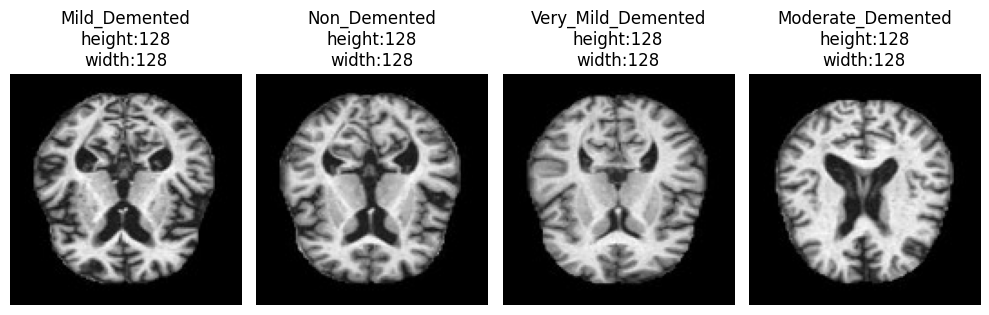

In [8]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


### Visualize the data

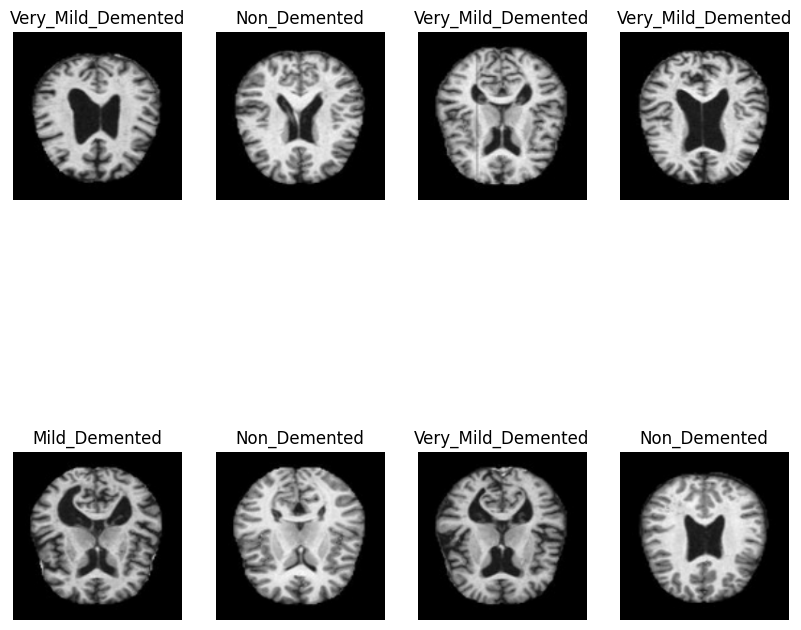

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Configure the data for higher performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardizing the dataset

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.9914226


### Create the Model

In [18]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

### Compile the Model

In [19]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
!nvidia-smi

Sat May  4 18:17:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0              29W /  70W |    235MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Train the Model

In [22]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
160/160 [==============================] - 11s 36ms/step - loss: 0.9525 - accuracy: 0.5557 - val_loss: 0.9528 - val_accuracy: 0.5641
Epoch 2/10
160/160 [==============================] - 3s 20ms/step - loss: 0.6947 - accuracy: 0.7029 - val_loss: 0.4887 - val_accuracy: 0.8125
Epoch 3/10
160/160 [==============================] - 3s 20ms/step - loss: 0.3738 - accuracy: 0.8504 - val_loss: 0.4492 - val_accuracy: 0.8023
Epoch 4/10
160/160 [==============================] - 3s 20ms/step - loss: 0.1371 - accuracy: 0.9537 - val_loss: 0.1473 - val_accuracy: 0.9484
Epoch 5/10
160/160 [==============================] - 3s 20ms/step - loss: 0.0616 - accuracy: 0.9789 - val_loss: 0.1285 - val_accuracy: 0.9461
Epoch 6/10
160/160 [==============================] - 3s 19ms/step - loss: 0.0192 - accuracy: 0.9967 - val_loss: 0.0433 - val_accuracy: 0.9883
Epoch 7/10
160/160 [==============================] - 3s 19ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.0370 - val_accuracy: 0.988

### Visualizing the results

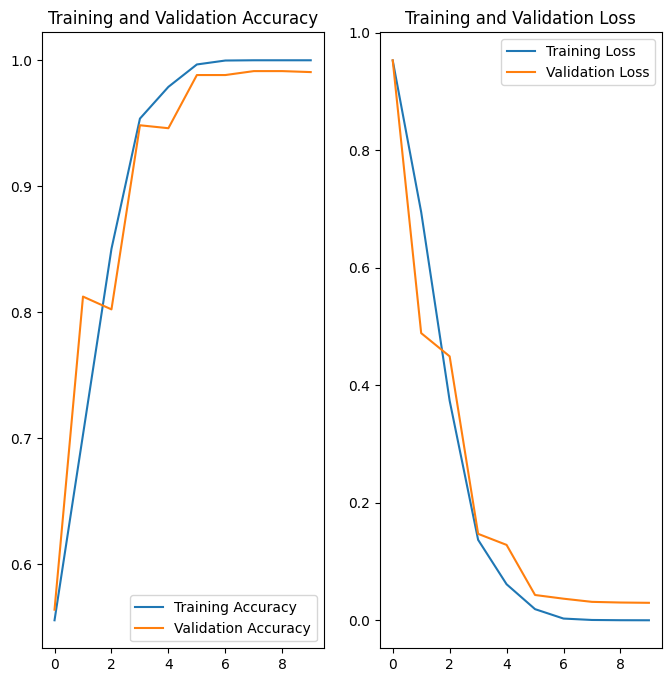

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data Augmentation

In [24]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

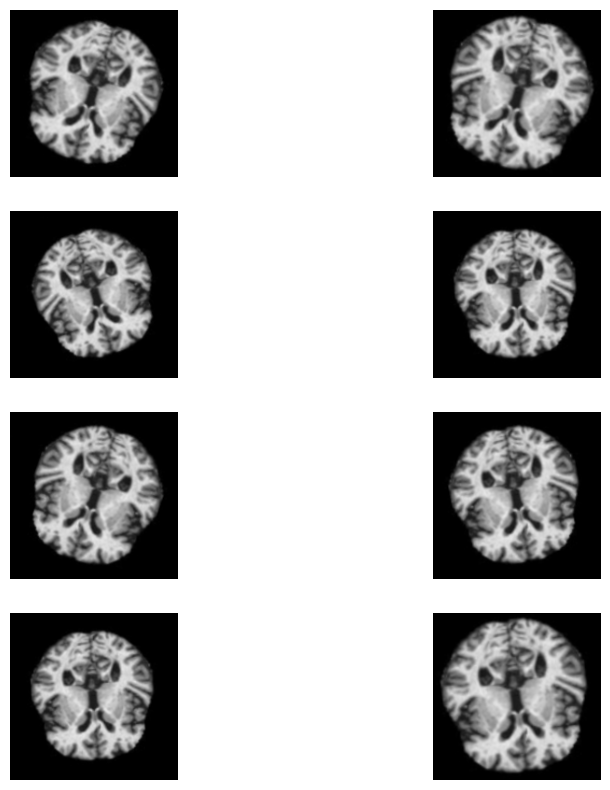

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Adding Dropout Layer

In [26]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [29]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
160/160 [==============================] - 7s 25ms/step - loss: 0.9839 - accuracy: 0.5309 - val_loss: 0.8258 - val_accuracy: 0.6133
Epoch 2/50
160/160 [==============================] - 4s 26ms/step - loss: 0.7308 - accuracy: 0.6824 - val_loss: 0.5576 - val_accuracy: 0.7625
Epoch 3/50
160/160 [==============================] - 4s 24ms/step - loss: 0.4723 - accuracy: 0.8105 - val_loss: 0.3775 - val_accuracy: 0.8609
Epoch 4/50
160/160 [==============================] - 4s 24ms/step - loss: 0.2781 - accuracy: 0.8934 - val_loss: 0.2533 - val_accuracy: 0.9102
Epoch 5/50
160/160 [==============================] - 4s 25ms/step - loss: 0.1667 - accuracy: 0.9373 - val_loss: 0.1424 - val_accuracy: 0.9461
Epoch 6/50
160/160 [==============================] - 4s 25ms/step - loss: 0.0993 - accuracy: 0.9645 - val_loss: 0.1993 - val_accuracy: 0.9187
Epoch 7/50
160/160 [==============================] - 4s 25ms/step - loss: 0.0655 - accuracy: 0.9752 - val_loss: 0.1599 - val_accuracy: 0.9367

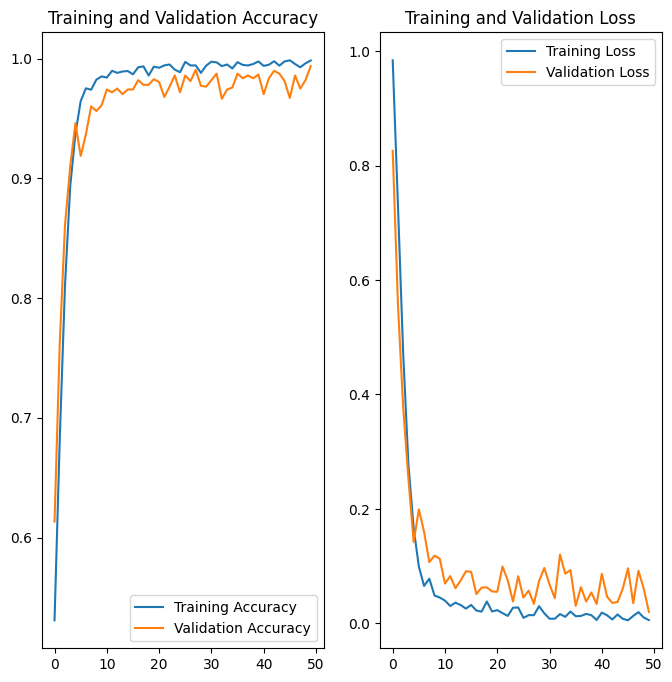

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix


40/40 [==============================] - 1s 11ms/step


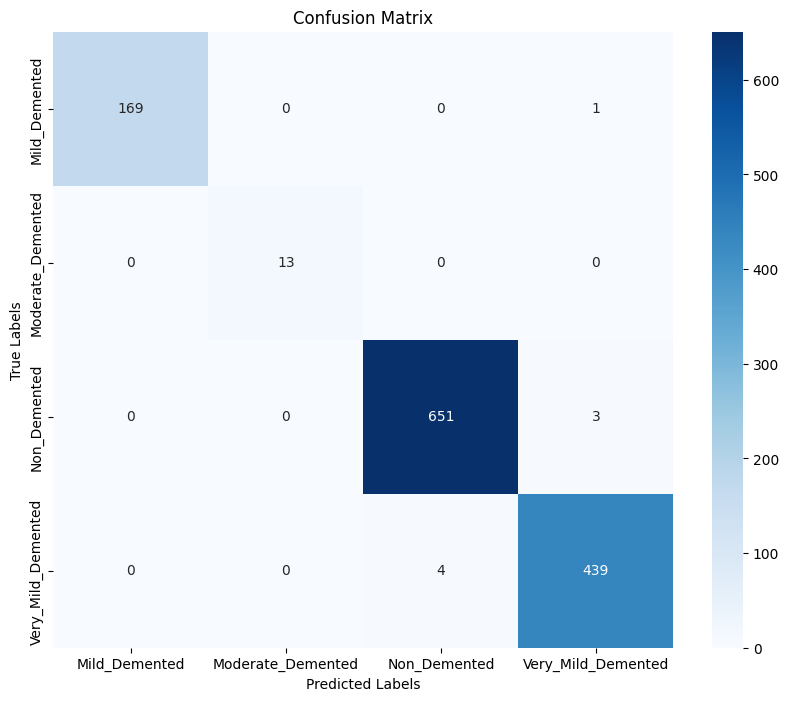

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predictions for the validation dataset
val_predictions = model.predict(val_ds)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Get the true labels for the validation dataset
val_true_labels = []
for images, labels in val_ds:
    val_true_labels.extend(labels.numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



Import Image


In [35]:
img = cv2.imread('/kaggle/input/random/IMG_20230328_201751.jpg')
img = cv2.resize(img,(180,180))
img_array = np.array(img)
img_array.shape

(180, 180, 3)

In [36]:
img_array = img_array.reshape(1,180,180,3)
img_array.shape

(1, 180, 180, 3)

Prediction

1/1 [==============================] - 0s 280ms/step


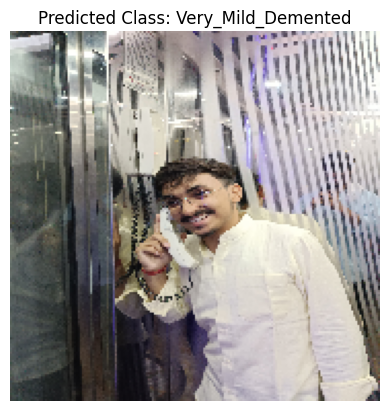

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load and preprocess the input image
input_image_path = "/kaggle/input/random/IMG_20230328_201751.jpg"  # Replace with the path to your input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
input_image = cv2.resize(input_image, (img_height, img_width))  # Resize to model input size
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
input_image = input_image / 255.0  # Normalize pixel values

# Make prediction
predictions = model.predict(input_image)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Display the input image and predicted class
plt.imshow(input_image[0])
plt.title(f"Predicted Class: {predicted_class}")
plt.axis("off")
plt.show()


### Save the Model

In [40]:
# Save the Keras model as an HDF5 file
model.save("alzeihmer_model.h5")